# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
import time

def SVMGridSearch(params_values):


    results = {}
    best_val = -1
    best_svm = None

    ################################################################################
    # TODO:                                                                        #
    # Use the validation set to set the learning rate and regularization strength. #
    # This should be identical to the validation that you did for the SVM; save    #
    # the best trained classifer in best_svm. You might also want to play          #
    # with different numbers of bins in the color histogram. If you are careful    #
    # you should be able to get accuracy of near 0.44 on the validation set.       #
    ################################################################################
    
    i = 0
    for (lr, reg) in params_values:
        svm = LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,num_iters=1500, verbose=False)
        toc = time.time()
        print('That took %fs' % (toc - tic))
        # training and validation set
        y_train_pred = svm.predict(X_train_feats)
        y_train_acc = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % y_train_acc)
        y_val_pred = svm.predict(X_val_feats)
        y_val_acc = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % y_val_acc)
        results[(lr, reg)]=(y_train_acc,y_val_acc)
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_svm = svm
    return (results,best_val,best_svm)
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################


In [37]:
learning_rates = [1e-5, 1e-7]
regularization_strengths = [0,2.5e4,5e4,7.5e4]
params_values = [(lr, reg) for lr in learning_rates
                                       for reg in regularization_strengths]
results,best_val,best_svm = SVMGridSearch(params_values)

That took 0.472237s
training accuracy: 0.412143
validation accuracy: 0.416000
That took 0.483707s
training accuracy: 0.385102
validation accuracy: 0.374000
That took 0.479716s
training accuracy: 0.373837
validation accuracy: 0.357000
That took 0.531672s
training accuracy: 0.344041
validation accuracy: 0.356000
That took 0.512641s
training accuracy: 0.112612
validation accuracy: 0.118000
That took 0.482713s
training accuracy: 0.284020
validation accuracy: 0.285000
That took 0.475733s
training accuracy: 0.407898
validation accuracy: 0.409000
That took 0.464766s
training accuracy: 0.415551
validation accuracy: 0.421000


In [38]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                        lr, reg, train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 0.000000e+00 train accuracy: 0.112612 val accuracy: 0.118000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.284020 val accuracy: 0.285000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.407898 val accuracy: 0.409000
lr 1.000000e-07 reg 7.500000e+04 train accuracy: 0.415551 val accuracy: 0.421000
lr 1.000000e-05 reg 0.000000e+00 train accuracy: 0.412143 val accuracy: 0.416000
lr 1.000000e-05 reg 2.500000e+04 train accuracy: 0.385102 val accuracy: 0.374000
lr 1.000000e-05 reg 5.000000e+04 train accuracy: 0.373837 val accuracy: 0.357000
lr 1.000000e-05 reg 7.500000e+04 train accuracy: 0.344041 val accuracy: 0.356000
best validation accuracy achieved during cross-validation: 0.421000


In [39]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.419


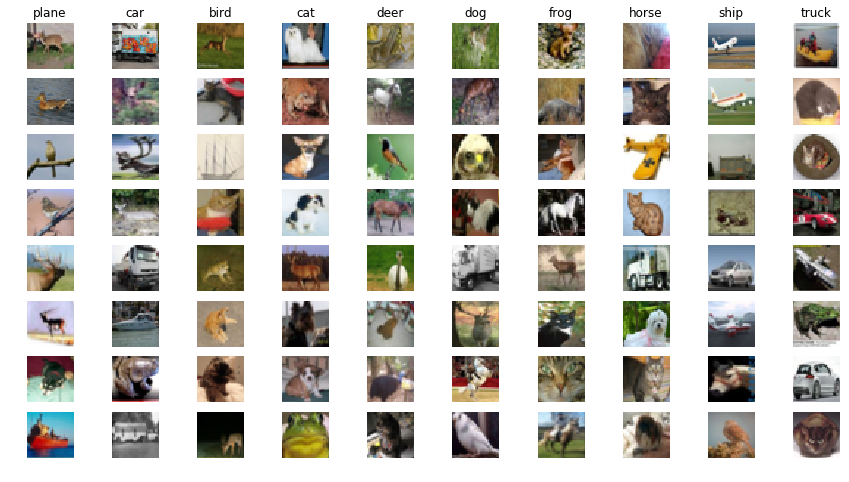

In [40]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
plt.figure(figsize=(15,8));

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [42]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


## Tuning Part:
- **Note: ** we will use multileveled GridSearch, meaning that we will not try all the compinations of values of the hype-parameters .. instead we will tune each hype-parameter on its own starting from the most important.
- we will set the values intuitively, when we tune parameter more than 1 time we are trying values in closer and closer range to the best value given.
- we will leave #epochs to the last that will make overall time for searching faster since we increase it after tuning other parameters and we are expecting that we would get higher results after increasing it.

In [43]:
from cs231n.classifiers.neural_net import TwoLayerNet
def GridSearch(params_values):
    input_size = X_train_feats.shape[1]

    num_classes = 10
    results = {}
    best_net = None
    best_val = -1
    ################################################################################
    # TODO: Train a two-layer neural network on image features. You may want to    #
    # cross-validate various parameters as in previous sections. Store your best   #
    # model in the best_net variable.                                              #
    ################################################################################

    # Predict on the validation set
    #val_acc = (net.predict(X_val) == y_val).mean()
    #print('Validation accuracy: ', val_acc)
    i = 0
    for (lr, reg,hidden_size,epoch_num) in params_values:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        tic = time.time()

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=epoch_num, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=reg, verbose=True)
        toc = time.time()
        print('That took %fs' % (toc - tic))
        # training and validation set
        y_train_pred = net.predict(X_train_feats)
        y_train_acc = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % y_train_acc)
        y_val_pred = net.predict(X_val_feats)
        y_val_acc = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % y_val_acc)
        results[(lr, reg,hidden_size,epoch_num)]=(y_train_acc,y_val_acc)
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_net = net
        # Plot the loss function and train / validation accuracies
        plt.subplot(2, 1, 1)
        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(2, 1, 2)
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Clasification accuracy')
        plt.legend()
        plt.show()
    return (results,best_val,best_net)
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################

In [45]:
def print_Scores(results,best_val):
    # Print out results.
    for lr, reg,hidden_size,epoch_num in sorted(results):
        train_accuracy, val_accuracy = results[(lr, reg,hidden_size,epoch_num)]
        print('lr %e reg %e hidden_size %d epoch_num %d train accuracy: %f val accuracy: %f' % (
                lr, reg,hidden_size,epoch_num, train_accuracy, val_accuracy))
                #print('%e,%e,%d,%d,%f,%f' % (
                #            lr, reg,hidden_size,epoch_num, train_accuracy, val_accuracy))
    print('best validation accuracy achieved during cross-validation: %f' % best_val)

# Tuning 1:
- tuning learning rates
- best values is near 1e-1

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302271
iteration 200 / 1000: loss 2.157359
iteration 300 / 1000: loss 1.878885
iteration 400 / 1000: loss 1.657822
iteration 500 / 1000: loss 1.494376
iteration 600 / 1000: loss 1.376380
iteration 700 / 1000: loss 1.272078
iteration 800 / 1000: loss 1.278026
iteration 900 / 1000: loss 1.465050
That took 3.981807s
training accuracy: 0.524776
validation accuracy: 0.511000


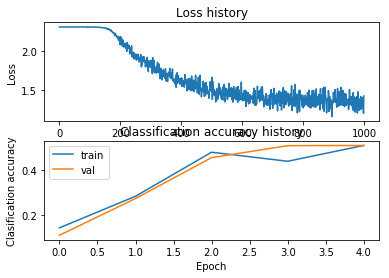

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.301487
iteration 200 / 1000: loss 2.137858
iteration 300 / 1000: loss 1.856739
iteration 400 / 1000: loss 1.612762
iteration 500 / 1000: loss 1.524819
iteration 600 / 1000: loss 1.376672
iteration 700 / 1000: loss 1.298958
iteration 800 / 1000: loss 1.379470
iteration 900 / 1000: loss 1.380240
That took 4.356485s
training accuracy: 0.523245
validation accuracy: 0.519000


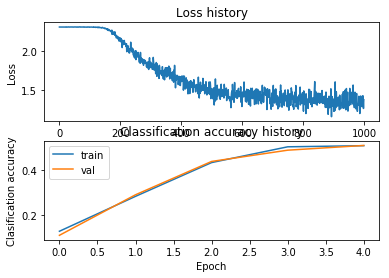

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302549
iteration 200 / 1000: loss 2.302685
iteration 300 / 1000: loss 2.302804
iteration 400 / 1000: loss 2.302457
iteration 500 / 1000: loss 2.302423
iteration 600 / 1000: loss 2.302846
iteration 700 / 1000: loss 2.302645
iteration 800 / 1000: loss 2.302440
iteration 900 / 1000: loss 2.302277
That took 4.589823s
training accuracy: 0.100082
validation accuracy: 0.098000


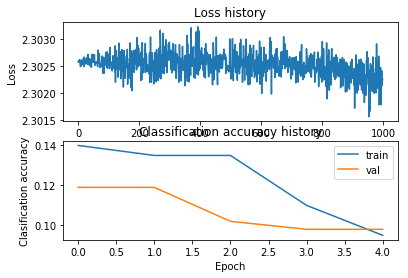

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302579
iteration 200 / 1000: loss 2.302679
iteration 300 / 1000: loss 2.302403
iteration 400 / 1000: loss 2.302912
iteration 500 / 1000: loss 2.302544
iteration 600 / 1000: loss 2.302763
iteration 700 / 1000: loss 2.302773
iteration 800 / 1000: loss 2.302355
iteration 900 / 1000: loss 2.302384
That took 4.510528s
training accuracy: 0.100510
validation accuracy: 0.079000


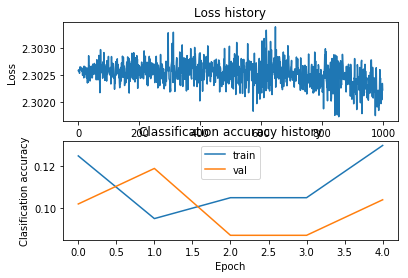

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302592
iteration 200 / 1000: loss 2.302606
iteration 300 / 1000: loss 2.302592
iteration 400 / 1000: loss 2.302613
iteration 500 / 1000: loss 2.302584
iteration 600 / 1000: loss 2.302590
iteration 700 / 1000: loss 2.302550
iteration 800 / 1000: loss 2.302613
iteration 900 / 1000: loss 2.302561
That took 4.561108s
training accuracy: 0.100449
validation accuracy: 0.078000


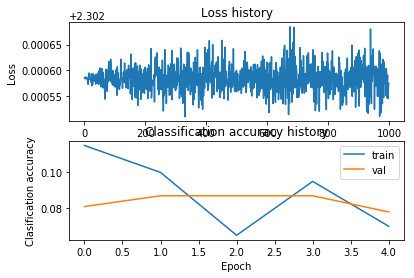

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302585
iteration 300 / 1000: loss 2.302601
iteration 400 / 1000: loss 2.302593
iteration 500 / 1000: loss 2.302555
iteration 600 / 1000: loss 2.302576
iteration 700 / 1000: loss 2.302581
iteration 800 / 1000: loss 2.302534
iteration 900 / 1000: loss 2.302619
That took 4.689112s
training accuracy: 0.100429
validation accuracy: 0.079000


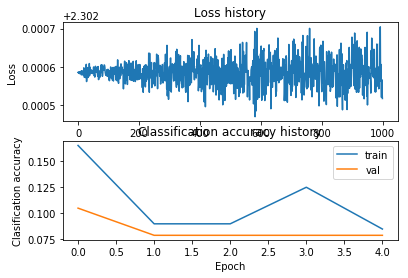

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302589
iteration 300 / 1000: loss 2.302586
iteration 400 / 1000: loss 2.302591
iteration 500 / 1000: loss 2.302586
iteration 600 / 1000: loss 2.302583
iteration 700 / 1000: loss 2.302583
iteration 800 / 1000: loss 2.302586
iteration 900 / 1000: loss 2.302588
That took 5.118082s
training accuracy: 0.121571
validation accuracy: 0.095000


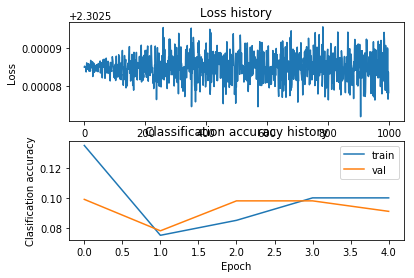

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302588
iteration 300 / 1000: loss 2.302585
iteration 400 / 1000: loss 2.302584
iteration 500 / 1000: loss 2.302582
iteration 600 / 1000: loss 2.302588
iteration 700 / 1000: loss 2.302575
iteration 800 / 1000: loss 2.302589
iteration 900 / 1000: loss 2.302585
That took 4.657778s
training accuracy: 0.100796
validation accuracy: 0.079000


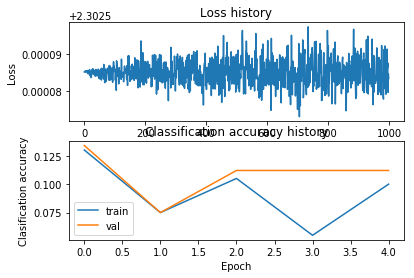

In [50]:
hidden_sizes = [500]
learning_rates = [1e-1,1e-2,1e-3,1e-4]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
regularization_strengths = [0,.000005]
epochs = [1000]
params_values = [(lr, reg,hidden_size,epoch_num) for lr in learning_rates
                                       for reg in regularization_strengths
                                       for hidden_size in hidden_sizes
                                        for epoch_num in epochs]
#params_values
results,best_val,best_net = GridSearch(params_values)

In [52]:
print_Scores(results,best_val)

lr 1.000000e-04 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.121571 val accuracy: 0.095000
lr 1.000000e-04 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.100796 val accuracy: 0.079000
lr 1.000000e-03 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.100449 val accuracy: 0.078000
lr 1.000000e-03 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.100429 val accuracy: 0.079000
lr 1.000000e-02 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.100082 val accuracy: 0.098000
lr 1.000000e-02 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.100510 val accuracy: 0.079000
lr 1.000000e-01 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.524776 val accuracy: 0.511000
lr 1.000000e-01 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.523245 val accuracy: 0.519000
best validation accuracy achieved during cross-validation: 0.519000


# Tuning 2:
- More tuning learning rates
- we will try closer range to the previous best value
- 4e-1,8e-1 both achieve close high score

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.300368
iteration 200 / 1000: loss 2.145251
iteration 300 / 1000: loss 1.821389
iteration 400 / 1000: loss 1.722509
iteration 500 / 1000: loss 1.444219
iteration 600 / 1000: loss 1.499269
iteration 700 / 1000: loss 1.306998
iteration 800 / 1000: loss 1.414457
iteration 900 / 1000: loss 1.332975
That took 4.619983s
training accuracy: 0.522061
validation accuracy: 0.523000


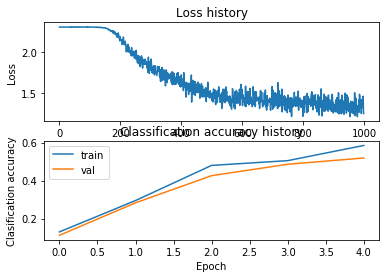

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.301308
iteration 200 / 1000: loss 2.140012
iteration 300 / 1000: loss 1.814913
iteration 400 / 1000: loss 1.673233
iteration 500 / 1000: loss 1.581501
iteration 600 / 1000: loss 1.483095
iteration 700 / 1000: loss 1.411529
iteration 800 / 1000: loss 1.391786
iteration 900 / 1000: loss 1.346778
That took 4.190863s
training accuracy: 0.522796
validation accuracy: 0.504000


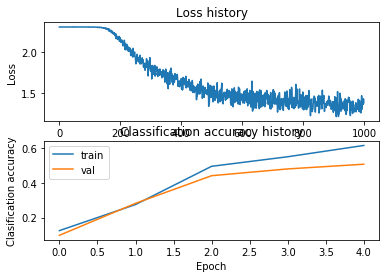

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.158171
iteration 200 / 1000: loss 1.687205
iteration 300 / 1000: loss 1.447867
iteration 400 / 1000: loss 1.398796
iteration 500 / 1000: loss 1.402128
iteration 600 / 1000: loss 1.224119
iteration 700 / 1000: loss 1.306151
iteration 800 / 1000: loss 1.298346
iteration 900 / 1000: loss 1.301765
That took 4.029958s
training accuracy: 0.562000
validation accuracy: 0.539000


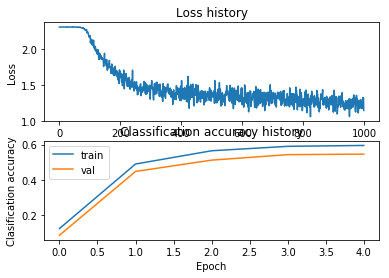

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.103298
iteration 200 / 1000: loss 1.654018
iteration 300 / 1000: loss 1.590389
iteration 400 / 1000: loss 1.365833
iteration 500 / 1000: loss 1.355366
iteration 600 / 1000: loss 1.214295
iteration 700 / 1000: loss 1.361796
iteration 800 / 1000: loss 1.182470
iteration 900 / 1000: loss 1.187551
That took 4.084142s
training accuracy: 0.563327
validation accuracy: 0.542000


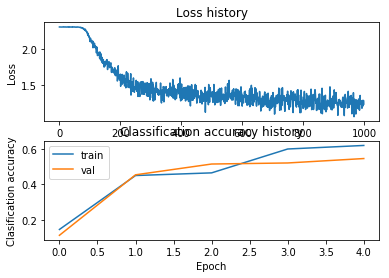

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.650008
iteration 200 / 1000: loss 1.414445
iteration 300 / 1000: loss 1.325734
iteration 400 / 1000: loss 1.288042
iteration 500 / 1000: loss 1.316019
iteration 600 / 1000: loss 1.152953
iteration 700 / 1000: loss 1.092541
iteration 800 / 1000: loss 1.081117
iteration 900 / 1000: loss 1.057543
That took 4.050494s
training accuracy: 0.624612
validation accuracy: 0.572000


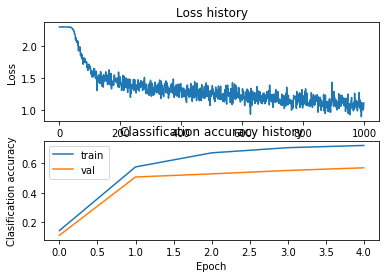

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.543121
iteration 200 / 1000: loss 1.499795
iteration 300 / 1000: loss 1.480643
iteration 400 / 1000: loss 1.277854
iteration 500 / 1000: loss 1.197841
iteration 600 / 1000: loss 1.125381
iteration 700 / 1000: loss 1.236721
iteration 800 / 1000: loss 1.168676
iteration 900 / 1000: loss 1.127997
That took 4.034995s
training accuracy: 0.624878
validation accuracy: 0.587000


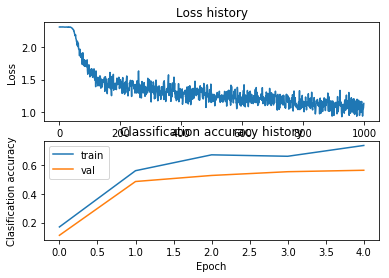

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.419540
iteration 200 / 1000: loss 1.329837
iteration 300 / 1000: loss 1.394609
iteration 400 / 1000: loss 1.271076
iteration 500 / 1000: loss 1.167219
iteration 600 / 1000: loss 1.128716
iteration 700 / 1000: loss 1.139752
iteration 800 / 1000: loss 1.013018
iteration 900 / 1000: loss 1.103643
That took 3.975132s
training accuracy: 0.658143
validation accuracy: 0.580000


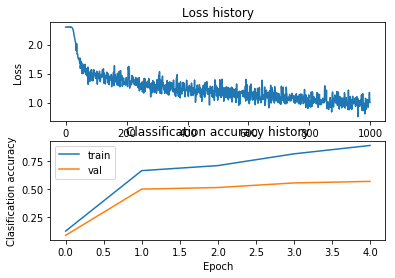

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.569548
iteration 200 / 1000: loss 1.362675
iteration 300 / 1000: loss 1.259272
iteration 400 / 1000: loss 1.079677
iteration 500 / 1000: loss 1.165941
iteration 600 / 1000: loss 1.188767
iteration 700 / 1000: loss 1.153066
iteration 800 / 1000: loss 1.198805
iteration 900 / 1000: loss 1.089717
That took 4.166715s
training accuracy: 0.651388
validation accuracy: 0.563000


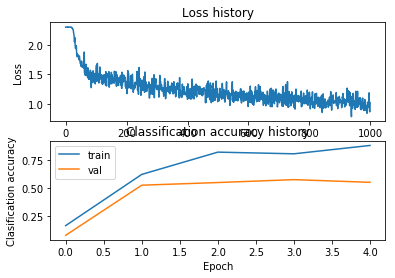

In [53]:
hidden_sizes = [500]
learning_rates = [1e-1,2e-1,4e-1,8e-1]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
regularization_strengths = [0,.000005]
epochs = [1000]
params_values = [(lr, reg,hidden_size,epoch_num) for lr in learning_rates
                                       for reg in regularization_strengths
                                       for hidden_size in hidden_sizes
                                        for epoch_num in epochs]
#params_values
results,best_val,best_net = GridSearch(params_values)

In [54]:
print_Scores(results,best_val)

lr 1.000000e-01 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.522061 val accuracy: 0.523000
lr 1.000000e-01 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.522796 val accuracy: 0.504000
lr 2.000000e-01 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.562000 val accuracy: 0.539000
lr 2.000000e-01 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.563327 val accuracy: 0.542000
lr 4.000000e-01 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.624612 val accuracy: 0.572000
lr 4.000000e-01 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.624878 val accuracy: 0.587000
lr 8.000000e-01 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.658143 val accuracy: 0.580000
lr 8.000000e-01 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.651388 val accuracy: 0.563000
best validation accuracy achieved during cross-validation: 0.587000


# Tuning 3:
- tuning hidden layer # of nodes
- for other hyper-parameters we put highest 2 best values
- best value was 750

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.532063
iteration 200 / 1000: loss 1.384622
iteration 300 / 1000: loss 1.439767
iteration 400 / 1000: loss 1.490242
iteration 500 / 1000: loss 1.217848
iteration 600 / 1000: loss 1.156199
iteration 700 / 1000: loss 1.197815
iteration 800 / 1000: loss 1.159906
iteration 900 / 1000: loss 1.119304
That took 8.418828s
training accuracy: 0.615041
validation accuracy: 0.571000


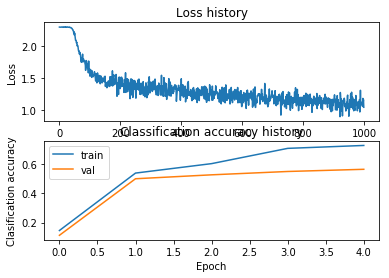

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.610959
iteration 200 / 1000: loss 1.444039
iteration 300 / 1000: loss 1.228432
iteration 400 / 1000: loss 1.357725
iteration 500 / 1000: loss 1.233277
iteration 600 / 1000: loss 1.322410
iteration 700 / 1000: loss 1.129716
iteration 800 / 1000: loss 1.265710
iteration 900 / 1000: loss 1.084196
That took 3.841011s
training accuracy: 0.622143
validation accuracy: 0.579000


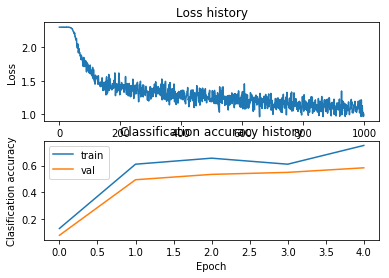

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.721267
iteration 200 / 1000: loss 1.414638
iteration 300 / 1000: loss 1.368447
iteration 400 / 1000: loss 1.327629
iteration 500 / 1000: loss 1.329450
iteration 600 / 1000: loss 1.219639
iteration 700 / 1000: loss 1.219511
iteration 800 / 1000: loss 1.150786
iteration 900 / 1000: loss 1.163680
That took 2.336382s
training accuracy: 0.616061
validation accuracy: 0.588000


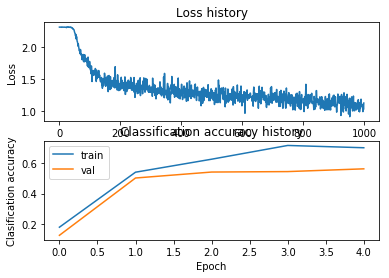

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.568978
iteration 200 / 1000: loss 1.445505
iteration 300 / 1000: loss 1.285326
iteration 400 / 1000: loss 1.330327
iteration 500 / 1000: loss 1.224052
iteration 600 / 1000: loss 1.145445
iteration 700 / 1000: loss 1.269781
iteration 800 / 1000: loss 1.199022
iteration 900 / 1000: loss 1.121588
That took 8.016856s
training accuracy: 0.621020
validation accuracy: 0.586000


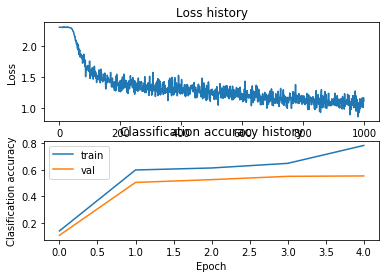

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.572642
iteration 200 / 1000: loss 1.461304
iteration 300 / 1000: loss 1.215917
iteration 400 / 1000: loss 1.215498
iteration 500 / 1000: loss 1.341088
iteration 600 / 1000: loss 1.243106
iteration 700 / 1000: loss 1.240505
iteration 800 / 1000: loss 1.153941
iteration 900 / 1000: loss 1.093900
That took 4.177943s
training accuracy: 0.616592
validation accuracy: 0.574000


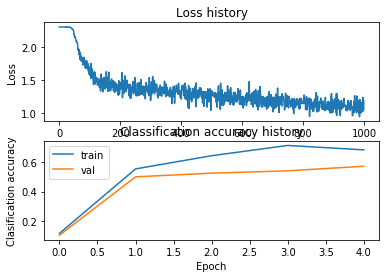

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.628243
iteration 200 / 1000: loss 1.448489
iteration 300 / 1000: loss 1.321502
iteration 400 / 1000: loss 1.327439
iteration 500 / 1000: loss 1.277300
iteration 600 / 1000: loss 1.196375
iteration 700 / 1000: loss 1.139451
iteration 800 / 1000: loss 1.149023
iteration 900 / 1000: loss 1.118257
That took 2.317377s
training accuracy: 0.613224
validation accuracy: 0.570000


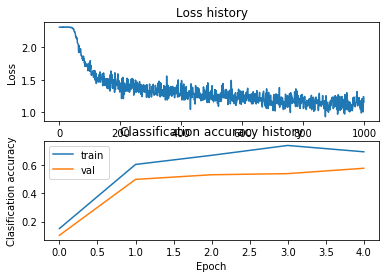

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.418251
iteration 200 / 1000: loss 1.295554
iteration 300 / 1000: loss 1.265677
iteration 400 / 1000: loss 1.216556
iteration 500 / 1000: loss 1.079799
iteration 600 / 1000: loss 1.188953
iteration 700 / 1000: loss 1.177842
iteration 800 / 1000: loss 1.214238
iteration 900 / 1000: loss 1.090863
That took 8.513962s
training accuracy: 0.676694
validation accuracy: 0.577000


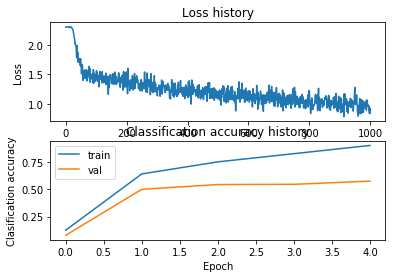

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.422962
iteration 200 / 1000: loss 1.459586
iteration 300 / 1000: loss 1.229324
iteration 400 / 1000: loss 1.352235
iteration 500 / 1000: loss 1.137942
iteration 600 / 1000: loss 1.010024
iteration 700 / 1000: loss 1.090515
iteration 800 / 1000: loss 1.169733
iteration 900 / 1000: loss 0.816976
That took 4.080058s
training accuracy: 0.667878
validation accuracy: 0.563000


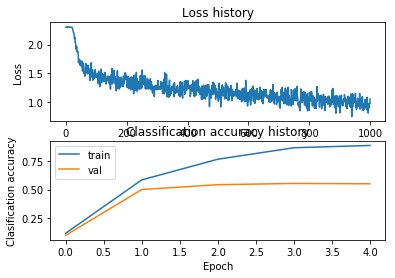

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.419913
iteration 200 / 1000: loss 1.505510
iteration 300 / 1000: loss 1.256740
iteration 400 / 1000: loss 1.028656
iteration 500 / 1000: loss 1.140269
iteration 600 / 1000: loss 1.175231
iteration 700 / 1000: loss 1.109415
iteration 800 / 1000: loss 1.095226
iteration 900 / 1000: loss 0.972434
That took 2.464236s
training accuracy: 0.647755
validation accuracy: 0.573000


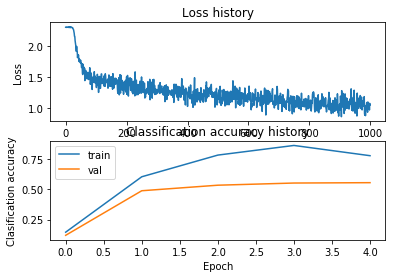

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.363454
iteration 200 / 1000: loss 1.340247
iteration 300 / 1000: loss 1.182678
iteration 400 / 1000: loss 1.155098
iteration 500 / 1000: loss 1.136160
iteration 600 / 1000: loss 1.270096
iteration 700 / 1000: loss 0.983244
iteration 800 / 1000: loss 0.988232
iteration 900 / 1000: loss 1.153884
That took 8.400175s
training accuracy: 0.663000
validation accuracy: 0.571000


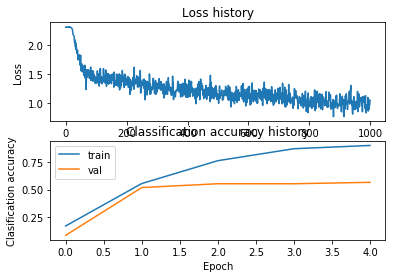

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.486502
iteration 200 / 1000: loss 1.587298
iteration 300 / 1000: loss 1.412571
iteration 400 / 1000: loss 1.371622
iteration 500 / 1000: loss 1.206363
iteration 600 / 1000: loss 1.117042
iteration 700 / 1000: loss 1.048484
iteration 800 / 1000: loss 1.230111
iteration 900 / 1000: loss 1.025368
That took 3.873410s
training accuracy: 0.661408
validation accuracy: 0.568000


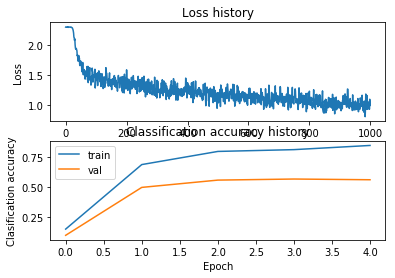

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.480562
iteration 200 / 1000: loss 1.443184
iteration 300 / 1000: loss 1.265232
iteration 400 / 1000: loss 1.211992
iteration 500 / 1000: loss 1.171153
iteration 600 / 1000: loss 1.255453
iteration 700 / 1000: loss 1.206687
iteration 800 / 1000: loss 1.218389
iteration 900 / 1000: loss 1.063201
That took 2.151727s
training accuracy: 0.652694
validation accuracy: 0.559000


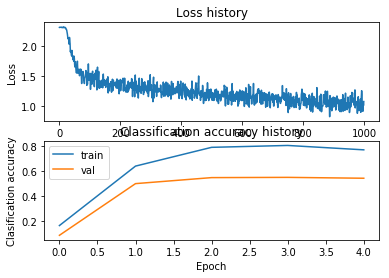

In [55]:
hidden_sizes = [750,500,250]
learning_rates = [4e-1,8e-1]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
regularization_strengths = [0,.000005]
epochs = [1000]
params_values = [(lr, reg,hidden_size,epoch_num) for lr in learning_rates
                                       for reg in regularization_strengths
                                       for hidden_size in hidden_sizes
                                        for epoch_num in epochs]
#params_values
results,best_val,best_net = GridSearch(params_values)

In [56]:
print_Scores(results,best_val)

lr 4.000000e-01 reg 0.000000e+00 hidden_size 250 epoch_num 1000 train accuracy: 0.616061 val accuracy: 0.588000
lr 4.000000e-01 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.622143 val accuracy: 0.579000
lr 4.000000e-01 reg 0.000000e+00 hidden_size 750 epoch_num 1000 train accuracy: 0.615041 val accuracy: 0.571000
lr 4.000000e-01 reg 5.000000e-06 hidden_size 250 epoch_num 1000 train accuracy: 0.613224 val accuracy: 0.570000
lr 4.000000e-01 reg 5.000000e-06 hidden_size 500 epoch_num 1000 train accuracy: 0.616592 val accuracy: 0.574000
lr 4.000000e-01 reg 5.000000e-06 hidden_size 750 epoch_num 1000 train accuracy: 0.621020 val accuracy: 0.586000
lr 8.000000e-01 reg 0.000000e+00 hidden_size 250 epoch_num 1000 train accuracy: 0.647755 val accuracy: 0.573000
lr 8.000000e-01 reg 0.000000e+00 hidden_size 500 epoch_num 1000 train accuracy: 0.667878 val accuracy: 0.563000
lr 8.000000e-01 reg 0.000000e+00 hidden_size 750 epoch_num 1000 train accuracy: 0.676694 val accuracy: 0

# Tuning 4:
- Tuning epochs is just increasing the # of epochs to considerable number
- as expected accuracy has increased

iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 1.584454
iteration 200 / 10000: loss 1.328892
iteration 300 / 10000: loss 1.288665
iteration 400 / 10000: loss 1.263989
iteration 500 / 10000: loss 1.261579
iteration 600 / 10000: loss 1.274901
iteration 700 / 10000: loss 1.276208
iteration 800 / 10000: loss 1.160508
iteration 900 / 10000: loss 1.101119
iteration 1000 / 10000: loss 1.161242
iteration 1100 / 10000: loss 1.010107
iteration 1200 / 10000: loss 0.987738
iteration 1300 / 10000: loss 0.909928
iteration 1400 / 10000: loss 0.976791
iteration 1500 / 10000: loss 0.916476
iteration 1600 / 10000: loss 0.910249
iteration 1700 / 10000: loss 0.980578
iteration 1800 / 10000: loss 0.870291
iteration 1900 / 10000: loss 0.919678
iteration 2000 / 10000: loss 0.905750
iteration 2100 / 10000: loss 0.687707
iteration 2200 / 10000: loss 0.818305
iteration 2300 / 10000: loss 0.811430
iteration 2400 / 10000: loss 0.873235
iteration 2500 / 10000: loss 0.681177
iteration 2600 / 10000: 

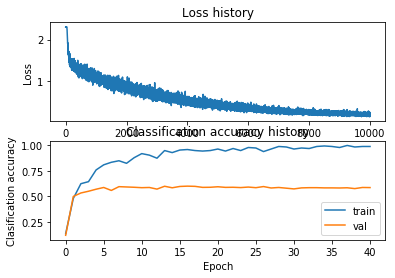

iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 1.584919
iteration 200 / 10000: loss 1.425672
iteration 300 / 10000: loss 1.377278
iteration 400 / 10000: loss 1.337595
iteration 500 / 10000: loss 1.257817
iteration 600 / 10000: loss 1.183057
iteration 700 / 10000: loss 1.243559
iteration 800 / 10000: loss 1.043925
iteration 900 / 10000: loss 1.063944
iteration 1000 / 10000: loss 1.046016
iteration 1100 / 10000: loss 1.094412
iteration 1200 / 10000: loss 1.014841
iteration 1300 / 10000: loss 1.083458
iteration 1400 / 10000: loss 1.060248
iteration 1500 / 10000: loss 0.962297
iteration 1600 / 10000: loss 0.856468
iteration 1700 / 10000: loss 0.889852
iteration 1800 / 10000: loss 0.939833
iteration 1900 / 10000: loss 0.924361
iteration 2000 / 10000: loss 0.792160
iteration 2100 / 10000: loss 0.738512
iteration 2200 / 10000: loss 0.796574
iteration 2300 / 10000: loss 0.913656
iteration 2400 / 10000: loss 0.728417
iteration 2500 / 10000: loss 0.745557
iteration 2600 / 10000: 

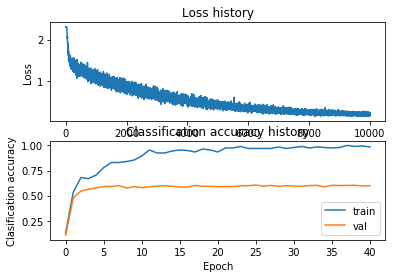

iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 1.481999
iteration 200 / 10000: loss 1.383380
iteration 300 / 10000: loss 1.206607
iteration 400 / 10000: loss 1.080317
iteration 500 / 10000: loss 1.127204
iteration 600 / 10000: loss 1.290065
iteration 700 / 10000: loss 1.042116
iteration 800 / 10000: loss 1.028350
iteration 900 / 10000: loss 1.104958
iteration 1000 / 10000: loss 0.907388
iteration 1100 / 10000: loss 0.900281
iteration 1200 / 10000: loss 0.823055
iteration 1300 / 10000: loss 0.995634
iteration 1400 / 10000: loss 0.760072
iteration 1500 / 10000: loss 0.927241
iteration 1600 / 10000: loss 0.895332
iteration 1700 / 10000: loss 0.737348
iteration 1800 / 10000: loss 0.620297
iteration 1900 / 10000: loss 0.749602
iteration 2000 / 10000: loss 0.640749
iteration 2100 / 10000: loss 0.690532
iteration 2200 / 10000: loss 0.622449
iteration 2300 / 10000: loss 0.532348
iteration 2400 / 10000: loss 0.694662
iteration 2500 / 10000: loss 0.480253
iteration 2600 / 10000: 

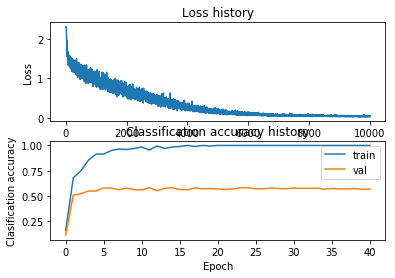

iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 1.385911
iteration 200 / 10000: loss 1.235821
iteration 300 / 10000: loss 1.248254
iteration 400 / 10000: loss 1.250034
iteration 500 / 10000: loss 1.288706
iteration 600 / 10000: loss 1.071213
iteration 700 / 10000: loss 1.033654
iteration 800 / 10000: loss 1.009643
iteration 900 / 10000: loss 0.957847
iteration 1000 / 10000: loss 1.011373
iteration 1100 / 10000: loss 0.991322
iteration 1200 / 10000: loss 0.894363
iteration 1300 / 10000: loss 0.930252
iteration 1400 / 10000: loss 0.698733
iteration 1500 / 10000: loss 0.764687
iteration 1600 / 10000: loss 0.880795
iteration 1700 / 10000: loss 0.850682
iteration 1800 / 10000: loss 0.730940
iteration 1900 / 10000: loss 0.659984
iteration 2000 / 10000: loss 0.752507
iteration 2100 / 10000: loss 0.622179
iteration 2200 / 10000: loss 0.609942
iteration 2300 / 10000: loss 0.552397
iteration 2400 / 10000: loss 0.545384
iteration 2500 / 10000: loss 0.474027
iteration 2600 / 10000: 

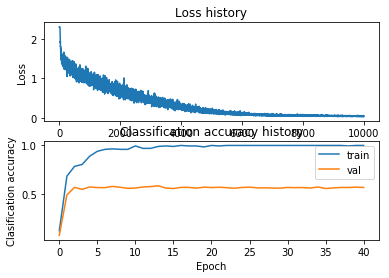

In [57]:
hidden_sizes = [750]
learning_rates = [4e-1,8e-1]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
regularization_strengths = [0,.000005]
epochs = [10000]
params_values = [(lr, reg,hidden_size,epoch_num) for lr in learning_rates
                                       for reg in regularization_strengths
                                       for hidden_size in hidden_sizes
                                        for epoch_num in epochs]
#params_values
results,best_val,best_net = GridSearch(params_values)

In [58]:
print_Scores(results,best_val)

lr 4.000000e-01 reg 0.000000e+00 hidden_size 750 epoch_num 10000 train accuracy: 0.967612 val accuracy: 0.583000
lr 4.000000e-01 reg 5.000000e-06 hidden_size 750 epoch_num 10000 train accuracy: 0.968000 val accuracy: 0.604000
lr 8.000000e-01 reg 0.000000e+00 hidden_size 750 epoch_num 10000 train accuracy: 0.999265 val accuracy: 0.572000
lr 8.000000e-01 reg 5.000000e-06 hidden_size 750 epoch_num 10000 train accuracy: 0.999408 val accuracy: 0.563000
best validation accuracy achieved during cross-validation: 0.604000


# Tuning 5:
- tuning reguralization
- we will try to increase reguralization penality since we want to decrease the gap between training and validation accuracy 
- the highest value was the best
- we gained about 61% validation accuracy

iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 1.526744
iteration 200 / 10000: loss 1.366465
iteration 300 / 10000: loss 1.325946
iteration 400 / 10000: loss 1.250971
iteration 500 / 10000: loss 1.272657
iteration 600 / 10000: loss 1.207125
iteration 700 / 10000: loss 1.155803
iteration 800 / 10000: loss 1.086279
iteration 900 / 10000: loss 1.098319
iteration 1000 / 10000: loss 1.070574
iteration 1100 / 10000: loss 0.995267
iteration 1200 / 10000: loss 1.037927
iteration 1300 / 10000: loss 1.016827
iteration 1400 / 10000: loss 1.022581
iteration 1500 / 10000: loss 0.866510
iteration 1600 / 10000: loss 1.007872
iteration 1700 / 10000: loss 0.966116
iteration 1800 / 10000: loss 1.037932
iteration 1900 / 10000: loss 0.881001
iteration 2000 / 10000: loss 0.702554
iteration 2100 / 10000: loss 0.771012
iteration 2200 / 10000: loss 0.804599
iteration 2300 / 10000: loss 0.642671
iteration 2400 / 10000: loss 0.730863
iteration 2500 / 10000: loss 0.780254
iteration 2600 / 10000: 

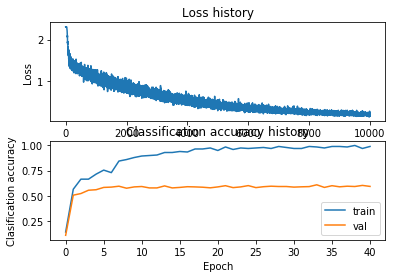

iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 1.673212
iteration 200 / 10000: loss 1.465242
iteration 300 / 10000: loss 1.395029
iteration 400 / 10000: loss 1.306714
iteration 500 / 10000: loss 1.166088
iteration 600 / 10000: loss 1.178892
iteration 700 / 10000: loss 1.103245
iteration 800 / 10000: loss 0.967623
iteration 900 / 10000: loss 1.192069
iteration 1000 / 10000: loss 1.146908
iteration 1100 / 10000: loss 1.142012
iteration 1200 / 10000: loss 1.154615
iteration 1300 / 10000: loss 0.981330
iteration 1400 / 10000: loss 1.021768
iteration 1500 / 10000: loss 1.031115
iteration 1600 / 10000: loss 1.073764
iteration 1700 / 10000: loss 0.828653
iteration 1800 / 10000: loss 0.842859
iteration 1900 / 10000: loss 0.848889
iteration 2000 / 10000: loss 0.923875
iteration 2100 / 10000: loss 0.831045
iteration 2200 / 10000: loss 0.947124
iteration 2300 / 10000: loss 0.704941
iteration 2400 / 10000: loss 0.592594
iteration 2500 / 10000: loss 0.685741
iteration 2600 / 10000: 

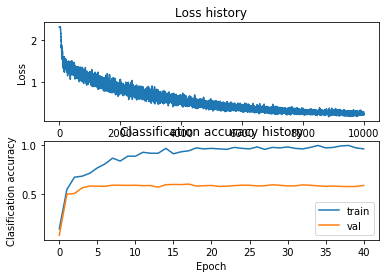

iteration 0 / 10000: loss 2.302586
iteration 100 / 10000: loss 1.679256
iteration 200 / 10000: loss 1.410791
iteration 300 / 10000: loss 1.327536
iteration 400 / 10000: loss 1.308168
iteration 500 / 10000: loss 1.304700
iteration 600 / 10000: loss 1.175684
iteration 700 / 10000: loss 1.214975
iteration 800 / 10000: loss 1.168269
iteration 900 / 10000: loss 1.054358
iteration 1000 / 10000: loss 1.115336
iteration 1100 / 10000: loss 1.190355
iteration 1200 / 10000: loss 1.136603
iteration 1300 / 10000: loss 1.153290
iteration 1400 / 10000: loss 1.144779
iteration 1500 / 10000: loss 1.164145
iteration 1600 / 10000: loss 1.050092
iteration 1700 / 10000: loss 1.001672
iteration 1800 / 10000: loss 0.941772
iteration 1900 / 10000: loss 0.966206
iteration 2000 / 10000: loss 1.026856
iteration 2100 / 10000: loss 1.018137
iteration 2200 / 10000: loss 1.003730
iteration 2300 / 10000: loss 0.917225
iteration 2400 / 10000: loss 0.999805
iteration 2500 / 10000: loss 1.015968
iteration 2600 / 10000: 

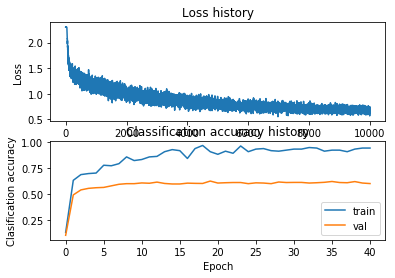

In [62]:
hidden_sizes = [750]
learning_rates = [4e-1]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
regularization_strengths = [1e-5,1e-4,1e-3]
epochs = [10000]
params_values = [(lr, reg,hidden_size,epoch_num) for lr in learning_rates
                                       for reg in regularization_strengths
                                       for hidden_size in hidden_sizes
                                        for epoch_num in epochs]
#params_values
results,best_val,best_net = GridSearch(params_values)

In [63]:
print_Scores(results,best_val)

lr 4.000000e-01 reg 1.000000e-05 hidden_size 750 epoch_num 10000 train accuracy: 0.966163 val accuracy: 0.594000
lr 4.000000e-01 reg 1.000000e-04 hidden_size 750 epoch_num 10000 train accuracy: 0.964551 val accuracy: 0.587000
lr 4.000000e-01 reg 1.000000e-03 hidden_size 750 epoch_num 10000 train accuracy: 0.894816 val accuracy: 0.613000
best validation accuracy achieved during cross-validation: 0.613000


# Tuning 6:
- more tuning reguralization
- we will try to increase reguralization penality but make the range between values and previous best value low..
- we gained about 61% validation and 60% test accuracy 

iteration 0 / 10000: loss 2.302586
iteration 100 / 10000: loss 1.686208
iteration 200 / 10000: loss 1.422427
iteration 300 / 10000: loss 1.440420
iteration 400 / 10000: loss 1.245982
iteration 500 / 10000: loss 1.228816
iteration 600 / 10000: loss 1.311507
iteration 700 / 10000: loss 1.105000
iteration 800 / 10000: loss 1.275946
iteration 900 / 10000: loss 1.011862
iteration 1000 / 10000: loss 1.027489
iteration 1100 / 10000: loss 1.049644
iteration 1200 / 10000: loss 1.084255
iteration 1300 / 10000: loss 0.959798
iteration 1400 / 10000: loss 1.061646
iteration 1500 / 10000: loss 1.057968
iteration 1600 / 10000: loss 1.138234
iteration 1700 / 10000: loss 1.046683
iteration 1800 / 10000: loss 1.079564
iteration 1900 / 10000: loss 1.102282
iteration 2000 / 10000: loss 1.020633
iteration 2100 / 10000: loss 0.979028
iteration 2200 / 10000: loss 0.976486
iteration 2300 / 10000: loss 0.888561
iteration 2400 / 10000: loss 0.977565
iteration 2500 / 10000: loss 0.879807
iteration 2600 / 10000: 

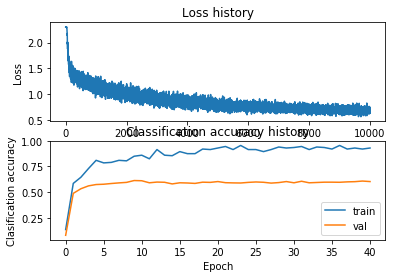

iteration 0 / 10000: loss 2.302586
iteration 100 / 10000: loss 1.601122
iteration 200 / 10000: loss 1.512649
iteration 300 / 10000: loss 1.290114
iteration 400 / 10000: loss 1.415502
iteration 500 / 10000: loss 1.258171
iteration 600 / 10000: loss 1.370573
iteration 700 / 10000: loss 1.245127
iteration 800 / 10000: loss 1.097502
iteration 900 / 10000: loss 1.273725
iteration 1000 / 10000: loss 1.206094
iteration 1100 / 10000: loss 1.249529
iteration 1200 / 10000: loss 1.226925
iteration 1300 / 10000: loss 1.184038
iteration 1400 / 10000: loss 1.156551
iteration 1500 / 10000: loss 1.061518
iteration 1600 / 10000: loss 1.110237
iteration 1700 / 10000: loss 1.081205
iteration 1800 / 10000: loss 1.111639
iteration 1900 / 10000: loss 1.113036
iteration 2000 / 10000: loss 1.073266
iteration 2100 / 10000: loss 1.025683
iteration 2200 / 10000: loss 0.961014
iteration 2300 / 10000: loss 1.051687
iteration 2400 / 10000: loss 1.051602
iteration 2500 / 10000: loss 1.054766
iteration 2600 / 10000: 

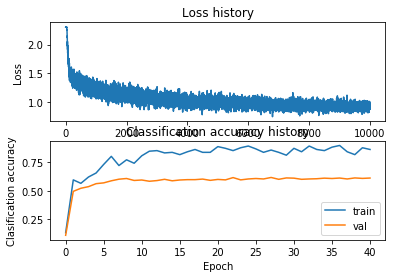

iteration 0 / 10000: loss 2.302587
iteration 100 / 10000: loss 1.701001
iteration 200 / 10000: loss 1.441028
iteration 300 / 10000: loss 1.522613
iteration 400 / 10000: loss 1.255353
iteration 500 / 10000: loss 1.385439
iteration 600 / 10000: loss 1.338609
iteration 700 / 10000: loss 1.317430
iteration 800 / 10000: loss 1.392965
iteration 900 / 10000: loss 1.366954
iteration 1000 / 10000: loss 1.349766
iteration 1100 / 10000: loss 1.341840
iteration 1200 / 10000: loss 1.460761
iteration 1300 / 10000: loss 1.277886
iteration 1400 / 10000: loss 1.228380
iteration 1500 / 10000: loss 1.247351
iteration 1600 / 10000: loss 1.347389
iteration 1700 / 10000: loss 1.353253
iteration 1800 / 10000: loss 1.256287
iteration 1900 / 10000: loss 1.316969
iteration 2000 / 10000: loss 1.304655
iteration 2100 / 10000: loss 1.075834
iteration 2200 / 10000: loss 1.250197
iteration 2300 / 10000: loss 1.338255
iteration 2400 / 10000: loss 1.262380
iteration 2500 / 10000: loss 1.186573
iteration 2600 / 10000: 

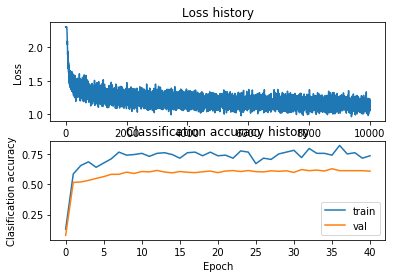

iteration 0 / 10000: loss 2.302590
iteration 100 / 10000: loss 1.641322
iteration 200 / 10000: loss 1.537049
iteration 300 / 10000: loss 1.492930
iteration 400 / 10000: loss 1.348615
iteration 500 / 10000: loss 1.385352
iteration 600 / 10000: loss 1.400773
iteration 700 / 10000: loss 1.396392
iteration 800 / 10000: loss 1.534835
iteration 900 / 10000: loss 1.481583
iteration 1000 / 10000: loss 1.310907
iteration 1100 / 10000: loss 1.338263
iteration 1200 / 10000: loss 1.384004
iteration 1300 / 10000: loss 1.330612
iteration 1400 / 10000: loss 1.451257
iteration 1500 / 10000: loss 1.393252
iteration 1600 / 10000: loss 1.530924
iteration 1700 / 10000: loss 1.466218
iteration 1800 / 10000: loss 1.366315
iteration 1900 / 10000: loss 1.349390
iteration 2000 / 10000: loss 1.490643
iteration 2100 / 10000: loss 1.390217
iteration 2200 / 10000: loss 1.434278
iteration 2300 / 10000: loss 1.369751
iteration 2400 / 10000: loss 1.426158
iteration 2500 / 10000: loss 1.273172
iteration 2600 / 10000: 

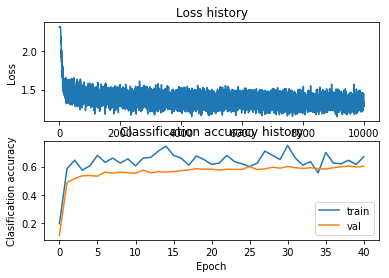

In [71]:
hidden_sizes = [750]
learning_rates = [4e-1]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
regularization_strengths = [1e-3,2e-3,4e-3,8e-3]
epochs = [10000]
params_values = [(lr, reg,hidden_size,epoch_num) for lr in learning_rates
                                       for reg in regularization_strengths
                                       for hidden_size in hidden_sizes
                                        for epoch_num in epochs]
#params_values
results,best_val,best_net = GridSearch(params_values)

In [72]:
print_Scores(results,best_val)

lr 4.000000e-01 reg 1.000000e-03 hidden_size 750 epoch_num 10000 train accuracy: 0.894837 val accuracy: 0.600000
lr 4.000000e-01 reg 2.000000e-03 hidden_size 750 epoch_num 10000 train accuracy: 0.824469 val accuracy: 0.609000
lr 4.000000e-01 reg 4.000000e-03 hidden_size 750 epoch_num 10000 train accuracy: 0.721898 val accuracy: 0.613000
lr 4.000000e-01 reg 8.000000e-03 hidden_size 750 epoch_num 10000 train accuracy: 0.627571 val accuracy: 0.589000
best validation accuracy achieved during cross-validation: 0.613000


In [73]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
def print_test_Score(best_net):
    test_acc = (best_net.predict(X_test_feats) == y_test).mean()
    print(test_acc)

In [74]:
print_test_Score(best_net)

0.602
